In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import haversine_distances

from catboost import CatBoostRegressor, Pool

pd.set_option('display.max_rows', 100)

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.drop_duplicates(inplace=True)
test_df = pd.read_csv('./data/test.csv')
print(f'Number of rows in training data: {train_df.shape[0]}')
print(f'Number of rows in test data: {test_df.shape[0]}')
train_df['lat_rads'] = np.radians(train_df['latitude'])
train_df['long_rads'] = np.radians(train_df['longitude'])
test_df['lat_rads'] = np.radians(test_df['latitude'])
test_df['long_rads'] = np.radians(test_df['longitude'])
train_df.head()

Number of rows in training data: 59727
Number of rows in test data: 30000


,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,lat_rads,long_rads
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,0.023466,1.810581
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,0.023216,1.814073
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,0.023252,1.812448
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,0.023915,1.814495
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,0.023047,1.812757


# Add stock market index value

In [3]:
# Get STI index values from start date to end date
train_df['rent_approval_date'] = pd.to_datetime(train_df['rent_approval_date'])
train_df['rent_approval_date'].sort_values()
test_df['rent_approval_date'] = pd.to_datetime(test_df['rent_approval_date'])
test_df['rent_approval_date'].sort_values()
start_date = min(train_df['rent_approval_date'].min(), test_df['rent_approval_date'].min()) - pd.DateOffset(days=1)
end_date = max(train_df['rent_approval_date'].max(), test_df['rent_approval_date'].max())
yf_df = yf.download('^STI', start=start_date, end=end_date)
yf_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,2853.600098,2861.610107,2843.810059,2843.810059,2843.810059,105602500
2021-01-04,2846.199951,2861.209961,2836.250000,2858.899902,2858.899902,172333900
2021-01-05,2842.060059,2859.679932,2832.040039,2859.679932,2859.679932,229983500
2021-01-06,2858.530029,2865.040039,2852.320068,2863.010010,2863.010010,257536900
2021-01-07,2892.330078,2912.699951,2884.179932,2906.969971,2906.969971,361145500


In [4]:
sti_df = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='d'))
sti_df = pd.merge(sti_df, yf_df[['Adj Close']], how='left', left_index=True, right_index=True)
sti_df.fillna(method='ffill', inplace=True)
sti_df.columns = ['sti']
sti_df

,sti
2020-12-31,2843.810059
2021-01-01,2843.810059
2021-01-02,2843.810059
2021-01-03,2843.810059
2021-01-04,2858.899902
...,...
2023-06-27,3205.350098
2023-06-28,3207.280029
2023-06-29,3207.280029
2023-06-30,3205.909912


In [5]:
# add sti values to train and test data
scaler = MinMaxScaler()
sti_df.loc[:,'sti'] = scaler.fit_transform(sti_df['sti'].values.reshape(-1, 1))
# find closest date to rent_approval_date
train_df['rent_approval_date'] = pd.to_datetime(train_df['rent_approval_date'])
test_df['rent_approval_date'] = pd.to_datetime(test_df['rent_approval_date'])
train_df['rent_approval_date'] = train_df['rent_approval_date'].dt.date
test_df['rent_approval_date'] = test_df['rent_approval_date'].dt.date
sti_df.index = sti_df.index.date
train_df['sti'] = train_df['rent_approval_date'].map(sti_df['sti'])
test_df['sti'] = test_df['rent_approval_date'].map(sti_df['sti'])

# COE Prices

In [6]:
coe_df = pd.read_csv('./data/auxiliary-data/sg-coe-prices.csv')
coe_df

,year,category,month,bidding,price,quota,bids
0,2023,a,july,2,95202,581,728
1,2023,a,july,1,97000,588,756
2,2023,a,june,2,96206,586,751
3,2023,a,june,1,98001,581,881
4,2023,a,may,2,92000,596,936
...,...,...,...,...,...,...,...
243,2021,e,march,1,47001,296,450
244,2021,e,february,2,47506,304,503
245,2021,e,february,1,49778,300,435
246,2021,e,january,2,51900,466,705


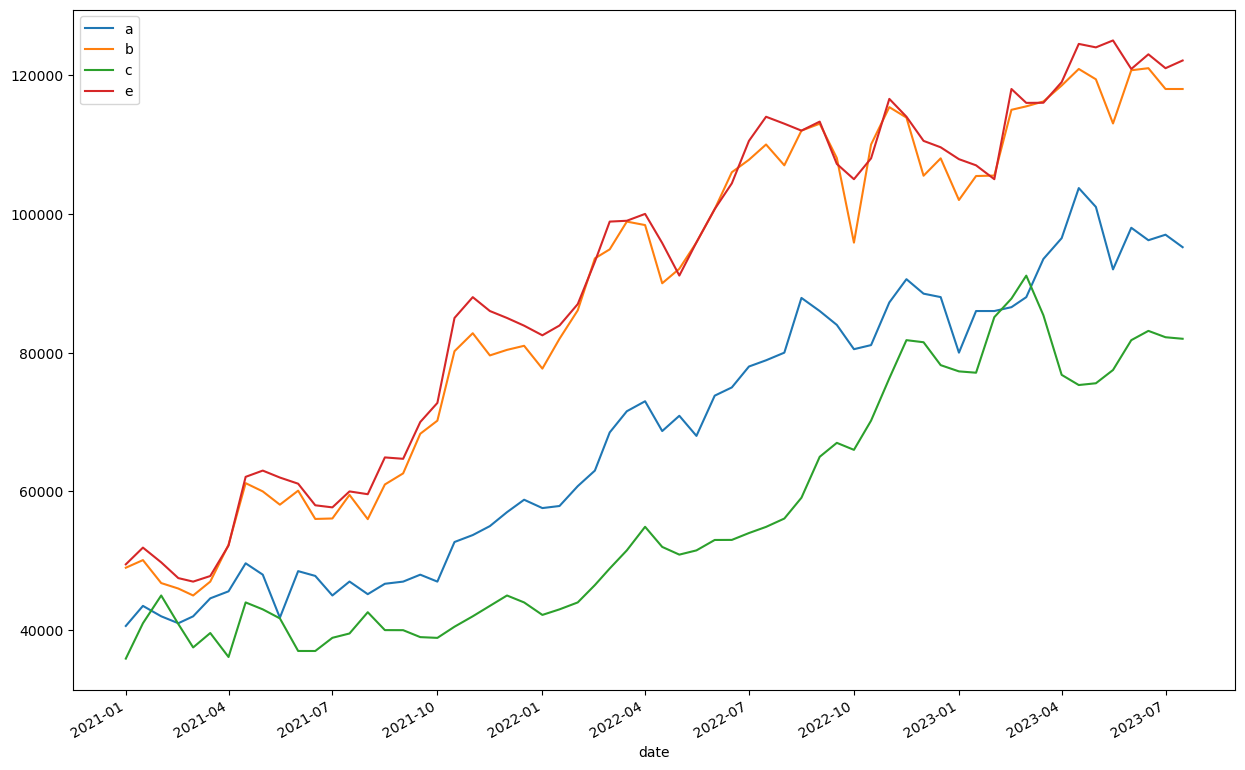

In [7]:
coe_df['date'] = (pd.to_datetime(coe_df['year'].astype(str)  + coe_df['month'], format='%Y%B'))
coe_df.loc[coe_df['bidding']==2, 'date'] += pd.DateOffset(days=15)
fig, ax = plt.subplots(figsize=(15, 10))
for cat in coe_df['category'].unique():
    coe_df[coe_df['category'] == cat].plot(x='date', y='price', ax=ax, label=cat)

In [8]:
coe_df['date'] = (pd.to_datetime(coe_df['year'].astype(str)  + coe_df['month'], format='%Y%B'))
print(coe_df['category'].unique())
coe_cal_date_df = pd.DataFrame({'price': np.nan}, index=pd.date_range(start_date, end_date, freq='d'))
for date in coe_df.loc[coe_df['category'] == 'e', 'date'].unique():
    coe_cal_date_df.loc[date, 'price'] = np.mean(coe_df.loc[(coe_df['category'] == 'e') & (coe_df['date'] == date), 'price'])
coe_cal_date_df.fillna(method='ffill', inplace=True)
coe_cal_date_df.columns = ['coe']
coe_cal_date_df.dropna(inplace=True)
coe_cal_date_df

['a' 'b' 'c' 'e']


,coe
2021-01-01,50694.5
2021-01-02,50694.5
2021-01-03,50694.5
2021-01-04,50694.5
2021-01-05,50694.5
...,...
2023-06-27,121944.5
2023-06-28,121944.5
2023-06-29,121944.5
2023-06-30,121944.5


In [9]:
# add coe values to train and test data
scaler = MinMaxScaler()
coe_cal_date_df.loc[:,'coe'] = scaler.fit_transform(coe_cal_date_df['coe'].values.reshape(-1, 1))
# find closest date to rent_approval_date
train_df['rent_approval_date'] = pd.to_datetime(train_df['rent_approval_date'])
test_df['rent_approval_date'] = pd.to_datetime(test_df['rent_approval_date'])
train_df['rent_approval_date'] = train_df['rent_approval_date'].dt.date
test_df['rent_approval_date'] = test_df['rent_approval_date'].dt.date
coe_cal_date_df.index = coe_cal_date_df.index.date
train_df['coe'] = train_df['rent_approval_date'].map(coe_cal_date_df['coe'])
test_df['coe'] = test_df['rent_approval_date'].map(coe_cal_date_df['coe'])

# Categorical variables

In [10]:
train_df['flat_type'] = train_df['flat_type'].str.replace('-', ' ')
# ordinal_cols_mapping = [{'col': 'flat_type', 'mapping': {'2 room': 2, '3 room': 3, '4 room': 4, '5 room': 5, 'executive': 6}},]

# Distance to good schools

In [11]:
school_df = pd.read_csv('./data/auxiliary-data/sg-primary-schools-processed.csv')
school_df.rename(columns={'name': 'School'}, inplace=True)

# convert latitudes and longitudes to radians
school_df['lat_rads'] = np.radians(school_df['latitude'])
school_df['long_rads'] = np.radians(school_df['longitude'])

print(school_df.shape)
school_df.head()

(185, 5)


,School,latitude,longitude,lat_rads,long_rads
0,Admiralty,1.454038,103.817436,0.025378,1.811956
1,Ahmad Ibrahim,1.433153,103.832942,0.025013,1.812227
2,Ai Tong,1.360583,103.833020,0.023747,1.812228
3,Alexandra,1.291334,103.824425,0.022538,1.812078
4,Anchor Green,1.390370,103.887165,0.024267,1.813173


In [12]:
# convert latitudes and longitudes to radians
distance = haversine_distances(train_df[['lat_rads', 'long_rads']], school_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
train_df['shortest_dist_school'] = distance.min(axis=1)
distance = haversine_distances(test_df[['lat_rads', 'long_rads']], school_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
test_df['shortest_dist_school'] = distance.min(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,elevation,subzone,planning_area,region,monthly_rent,lat_rads,long_rads,sti,coe,shortest_dist_school
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,0.0,yuhua east,jurong east,west region,1600,0.023466,1.810581,0.405905,0.258731,0.334846
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978,1.330186,...,0.0,bedok north,bedok,east region,2250,0.023216,1.814073,0.853443,0.597983,0.607716
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971,1.332242,...,0.0,toa payoh central,toa payoh,central region,1900,0.023252,1.812448,0.476430,0.766542,0.425760
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,...,0.0,pasir ris drive,pasir ris,east region,2850,0.023915,1.814495,0.537475,0.192568,0.564969
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972,1.320502,...,0.0,bendemeer,kallang,central region,2100,0.023047,1.812757,0.476863,0.880567,0.271723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09-01,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,...,0.0,chong boon,ang mo kio,north-east region,2200,0.023842,1.812597,0.405905,0.258731,0.360651
59996,2023-04-01,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2019,1.286493,...,0.0,henderson hill,bukit merah,central region,4100,0.022454,1.812026,0.690436,0.964260,0.562691
59997,2022-06-01,tampines,862a,tampines street 83,5 room,improved,122.0,yes,1988,1.355064,...,0.0,tampines west,tampines,east region,2250,0.023650,1.814034,0.665652,0.715263,0.320031
59998,2023-01-01,bedok,67,Bedok Sth Avenue 3,5 room,standard,123.0,yes,1977,1.318974,...,0.0,bedok south,bedok,east region,4700,0.023020,1.814166,0.677828,0.778767,0.219549


In [13]:
ballot_df = pd.read_csv('./data/auxiliary-data/sg-school-balloting-processed.csv')
print(ballot_df.shape)
ballot_df.head()

(181, 5)


,School,Phase 1,2A,2B,2C
0,Admiralty,0.500000,0.426667,1.088235,1.557143
1,Ahmad Ibrahim,0.337500,0.094340,0.000000,0.171975
2,Ai Tong,0.475000,0.952381,2.545455,1.733333
3,Alexandra,0.407143,0.156627,0.093023,1.110236
4,Anchor Green,0.472222,0.315789,0.000000,0.281250


In [14]:
school_df = school_df.merge(ballot_df, on='School', how='left')
school_df.head()

,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
0,Admiralty,1.454038,103.817436,0.025378,1.811956,0.500000,0.426667,1.088235,1.557143
1,Ahmad Ibrahim,1.433153,103.832942,0.025013,1.812227,0.337500,0.094340,0.000000,0.171975
2,Ai Tong,1.360583,103.833020,0.023747,1.812228,0.475000,0.952381,2.545455,1.733333
3,Alexandra,1.291334,103.824425,0.022538,1.812078,0.407143,0.156627,0.093023,1.110236
4,Anchor Green,1.390370,103.887165,0.024267,1.813173,0.472222,0.315789,0.000000,0.281250


In [15]:
school_df[school_df.isna().any(axis=1)] = school_df[school_df.isna().any(axis=1)].fillna(0)
school_df.isna().sum()

School       0
latitude     0
longitude    0
lat_rads     0
long_rads    0
Phase 1      0
2A           0
2B           0
2C           0
dtype: int64

In [16]:
school_df.describe()

,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.363017,103.842126,0.023789,1.812387,0.441880,0.524625,0.447522,1.002233
std,0.042669,0.071838,0.000745,0.001254,0.152676,0.460166,0.674936,0.896141
min,1.274958,103.687770,0.022252,1.809693,0.000000,0.000000,0.000000,0.000000
25%,1.334762,103.786035,0.023296,1.811408,0.337500,0.183099,0.000000,0.350000
50%,1.357651,103.845523,0.023695,1.812446,0.463636,0.385965,0.062500,0.781250
75%,1.390302,103.899078,0.024265,1.813381,0.550000,0.781609,0.687500,1.389831
max,1.456608,103.961677,0.025423,1.814474,0.800000,3.543478,3.400000,5.895833


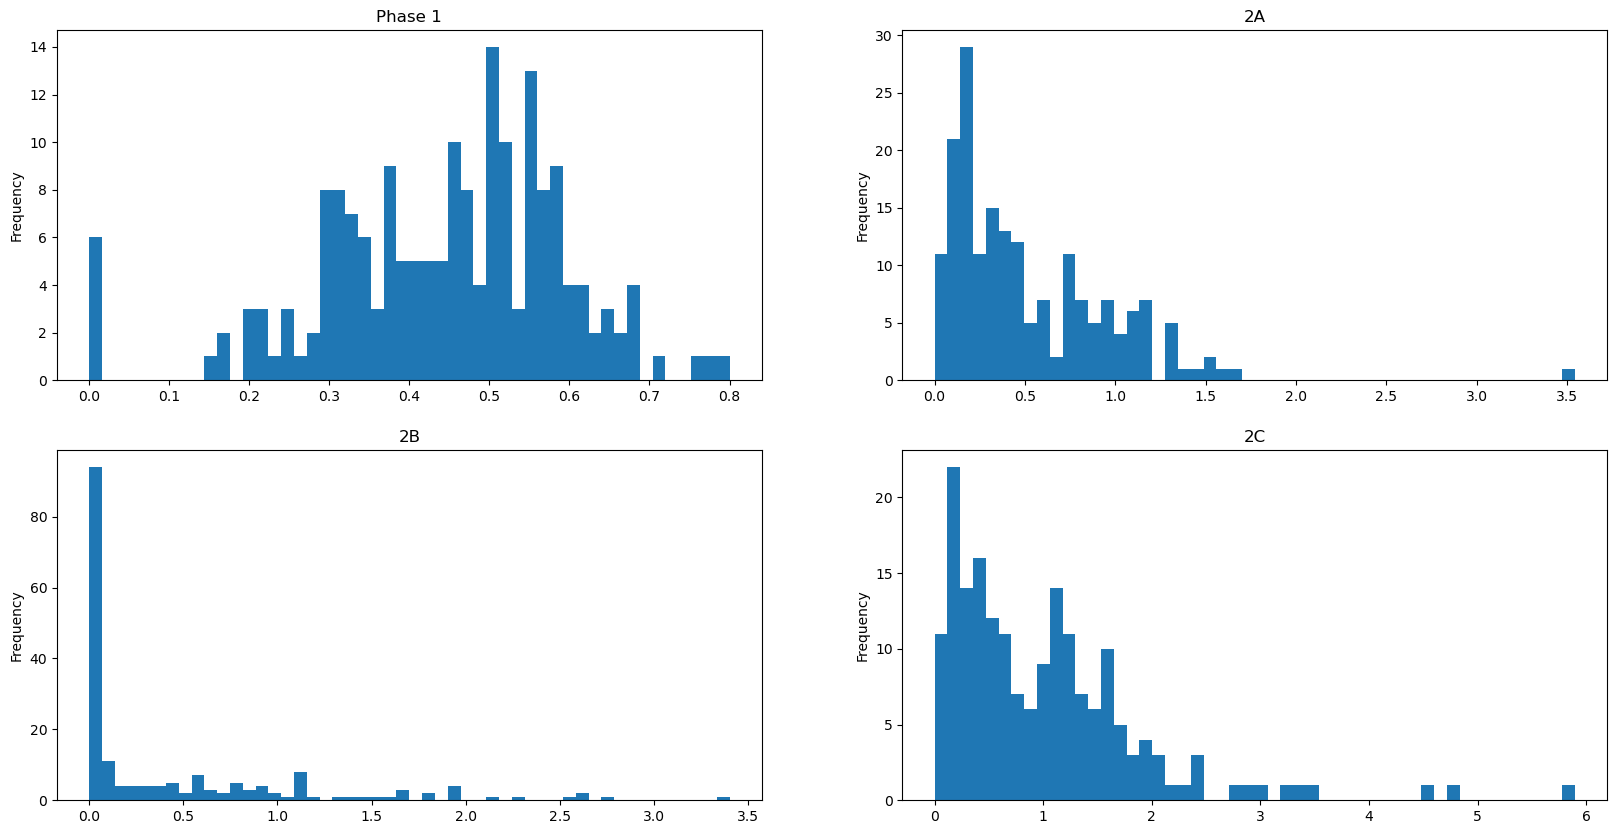

In [17]:
# Example distribution of subscription ratios
cols = school_df.columns[5:]
n = len(cols) // 2
fig,ax = plt.subplots(2, n, figsize=(20, 10))
for i, col in enumerate(cols):
    school_df[col].plot(ax=ax[i//n, i%n], kind='hist', bins=50)
    ax[i//n, i%n].set_title(col)

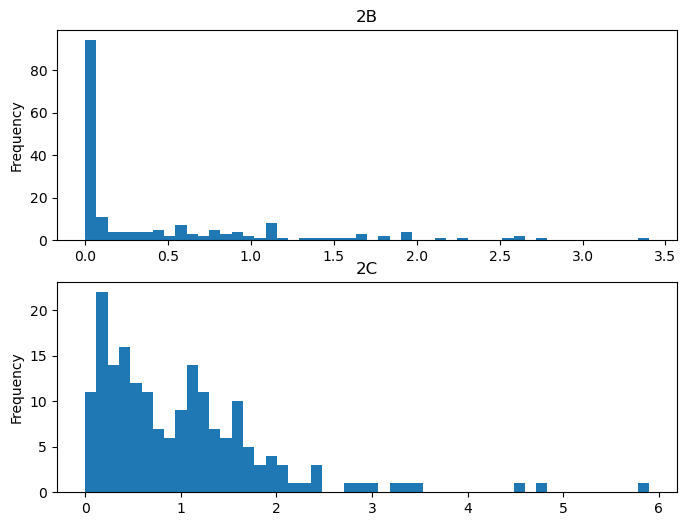

In [18]:
# Example distribution of subscription ratios
cols = school_df.columns[7:]
fig,ax = plt.subplots(2, figsize=(8, 6))
for i, col in enumerate(cols):
    school_df[col].plot(ax=ax[i], kind='hist', bins=50)
    ax[i].set_title(col)

In [19]:
# set thresholds for each category
top_threshold = 1.8
good_threshold = 1.0
sch_cats = {}

In [20]:
# use phase 2B and 2C subscription ratios to categorise schools
sch_cats['top'] = school_df[(school_df['2B'] >= top_threshold) | (school_df['2C'] >= top_threshold)]
print(len(sch_cats['top']))
sch_cats['top']

31


,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
2,Ai Tong,1.360583,103.833020,0.023747,1.812228,0.475000,0.952381,2.545455,1.733333
7,Anglo-Chinese,1.318371,103.835610,0.023010,1.812273,0.311111,0.854839,1.961538,1.283019
15,Bukit Panjang,1.373622,103.769375,0.023974,1.811117,0.555556,0.975000,1.142857,2.119048
30,CHIJ (Toa Payoh),1.332753,103.841847,0.023261,1.812382,0.340000,0.780000,1.962963,1.254545
31,CHIJ St. Nicholas Girls,1.373979,103.834240,0.023980,1.812249,0.466667,1.287500,2.300000,2.100000
51,Fairfield Methodist,1.301004,103.785456,0.022707,1.811398,0.552381,1.095745,2.600000,1.650000
61,Gongshang,1.357116,103.949145,0.023686,1.814255,0.712500,3.543478,0.800000,2.431818
66,Holy Innocents,1.366938,103.894115,0.023858,1.813294,0.509524,1.116505,2.650000,2.875000
68,Hong Wen,1.321760,103.857628,0.023069,1.812658,0.546667,0.492754,0.937500,2.188406
69,Horizon,1.399550,103.913405,0.024427,1.813631,0.572222,1.363636,0.800000,1.840909


In [21]:
sch_cats['good'] = school_df[((school_df['2B'] < top_threshold) & (school_df['2C'] < top_threshold)) & ((school_df['2B'] >= good_threshold) | (school_df['2C'] >= good_threshold))]
print(len(sch_cats['good']))
sch_cats['good']

53


,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
0,Admiralty,1.454038,103.817436,0.025378,1.811956,0.500000,0.426667,1.088235,1.557143
3,Alexandra,1.291334,103.824425,0.022538,1.812078,0.407143,0.156627,0.093023,1.110236
5,Anderson,1.384264,103.841392,0.024160,1.812374,0.473333,0.582278,0.612903,1.243243
6,Anglo-Chinese (Junior),1.309350,103.840950,0.022852,1.812366,0.361905,0.753731,1.677419,1.274194
8,Angsana,1.348553,103.951808,0.023537,1.814301,0.400000,0.719697,0.062500,1.757895
18,Canberra,1.451250,103.815859,0.025329,1.811929,0.444444,0.160000,0.458333,1.073770
19,Canossa Catholic,1.326644,103.882228,0.023154,1.813087,0.800000,0.250000,0.826087,1.120000
22,Catholic High,1.354389,103.844211,0.023639,1.812423,0.355556,1.163793,1.450000,1.300000
28,CHIJ Our Lady of the Nativity,1.373574,103.897769,0.023973,1.813358,0.333333,0.200000,0.865385,1.018018
32,Chongfu,1.438396,103.839309,0.025105,1.812338,0.508333,0.618644,1.514286,1.555556


In [22]:
sch_cats['normal'] = school_df[(school_df['2B'] < good_threshold) & (school_df['2C'] < good_threshold)]
print(len(sch_cats['normal']))
sch_cats['normal']

101


,School,latitude,longitude,lat_rads,long_rads,Phase 1,2A,2B,2C
1,Ahmad Ibrahim,1.433153,103.832942,0.025013,1.812227,0.337500,0.094340,0.000000,0.171975
4,Anchor Green,1.390370,103.887165,0.024267,1.813173,0.472222,0.315789,0.000000,0.281250
9,Ang Mo Kio,1.365588,103.850957,0.023834,1.812541,0.355556,0.568966,0.000000,0.341176
10,Beacon,1.383949,103.773632,0.024154,1.811192,0.666667,0.200000,0.000000,0.369048
11,Bedok Green,1.323446,103.937879,0.023098,1.814058,0.380000,0.117021,0.000000,0.188811
...,...,...,...,...,...,...,...,...,...
180,Yuhua,1.342802,103.741106,0.023436,1.810624,0.316667,0.186992,0.018868,0.143750
181,Yumin,1.351292,103.950462,0.023584,1.814278,0.293750,0.106195,0.000000,0.086957
182,Zhangde,1.284212,103.825952,0.022414,1.812105,0.525000,0.385965,0.000000,0.926316
183,Zhenghua,1.379549,103.769314,0.024078,1.811116,0.520000,0.763889,0.076923,0.578947


In [23]:
# map latitudes and longitudes to radians
for key in sch_cats.keys():
    distance = haversine_distances(train_df[['lat_rads', 'long_rads']], sch_cats[key][['lat_rads', 'long_rads']])
    distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
    train_df[f'num_{key}_sch_1km'] = (distance < 1).sum(axis=1)
    train_df[f'num_{key}_sch_2km'] = (distance < 2).sum(axis=1)
    distance = haversine_distances(test_df[['lat_rads', 'long_rads']], sch_cats[key][['lat_rads', 'long_rads']])
    distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
    test_df[f'num_{key}_sch_1km'] = (distance < 1).sum(axis=1)
    test_df[f'num_{key}_sch_2km'] = (distance < 2).sum(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,long_rads,sti,coe,shortest_dist_school,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,...,1.810581,0.405905,0.258731,0.334846,1,1,0,2,2,4
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978,1.330186,...,1.814073,0.853443,0.597983,0.607716,1,2,1,1,3,6
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971,1.332242,...,1.812448,0.476430,0.766542,0.425760,1,4,0,1,1,3
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,...,1.814495,0.537475,0.192568,0.564969,0,0,2,2,1,4
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972,1.320502,...,1.812757,0.476863,0.880567,0.271723,1,1,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09-01,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979,1.366050,...,1.812597,0.405905,0.258731,0.360651,0,0,1,3,4,6
59996,2023-04-01,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2019,1.286493,...,1.812026,0.690436,0.964260,0.562691,0,0,1,4,2,4
59997,2022-06-01,tampines,862a,tampines street 83,5 room,improved,122.0,yes,1988,1.355064,...,1.814034,0.665652,0.715263,0.320031,2,3,0,2,2,5
59998,2023-01-01,bedok,67,Bedok Sth Avenue 3,5 room,standard,123.0,yes,1977,1.318974,...,1.814166,0.677828,0.778767,0.219549,1,2,0,0,1,3


# Convert lease_commence_date to age and discretise to bins

<Axes: ylabel='Frequency'>

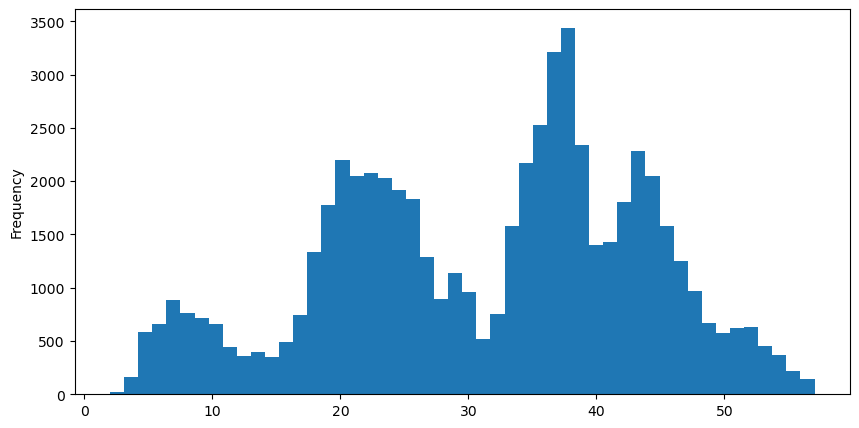

In [24]:
train_df['rent_approval_date'] = train_df['rent_approval_date'].astype("datetime64[ns]")
train_df["lease_commence_date"] = pd.to_datetime(train_df["lease_commence_date"].astype(str), format='%Y')#.astype('datetime64[ns]')
train_df["age"] = (train_df["rent_approval_date"] - train_df["lease_commence_date"])/np.timedelta64(1, 'Y')
train_df['age'].plot(kind='hist', bins=50, figsize=(10, 5))

<Axes: ylabel='Frequency'>

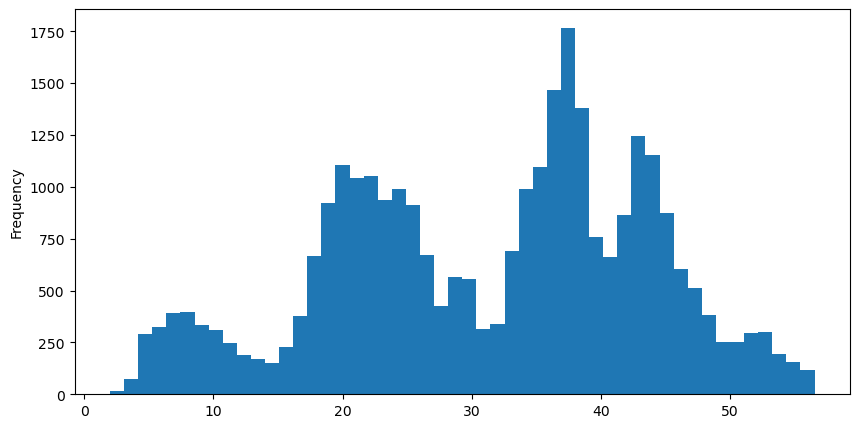

In [25]:
test_df['rent_approval_date'] = test_df['rent_approval_date'].astype("datetime64[ns]")
test_df["lease_commence_date"] = pd.to_datetime(test_df["lease_commence_date"].astype(str), format='%Y')#.astype('datetime64[ns]')
test_df["age"] = (test_df["rent_approval_date"] - test_df["lease_commence_date"])/np.timedelta64(1, 'Y')
test_df['age'].plot(kind='hist', bins=50, figsize=(10, 5))

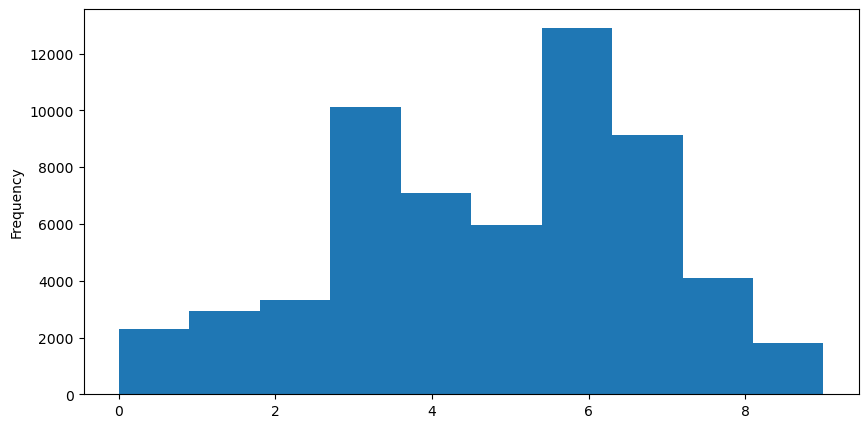

In [26]:
n_age_bins = 10
age_KBD = KBinsDiscretizer(n_bins=n_age_bins, encode='ordinal', strategy='uniform')
age_KBD.fit(train_df[['age']])
age_KBD.bin_edges_
train_df['age_bin'] = age_KBD.transform(train_df[['age']]).astype(int)
train_df['age_bin'].plot(kind='hist', bins=n_age_bins, figsize=(10, 5))
test_df['age_bin'] = age_KBD.transform(test_df[['age']]).astype(int)

# Proximity to malls

In [27]:
mall_df = pd.read_csv('./data/auxiliary-data/sg-shopping-malls.csv')
mall_df.head()

,name,latitude,longitude
0,100 AM,1.274588,103.843471
1,313@Somerset,1.301385,103.837684
2,Aperia,1.310867,103.863930
3,Balestier Hill Shopping Centre,1.325596,103.842572
4,Bugis Cube,1.298141,103.855635


In [28]:
# convert latitudes and longitudes to radians
mall_df['lat_rads'] = np.radians(mall_df['latitude'])
mall_df['long_rads'] = np.radians(mall_df['longitude'])
distance = haversine_distances(train_df[['lat_rads', 'long_rads']], mall_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
train_df['shortest_dist_mall'] = distance.min(axis=1)
distance = haversine_distances(test_df[['lat_rads', 'long_rads']], mall_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
test_df['shortest_dist_mall'] = distance.min(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,shortest_dist_school,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,0.334846,1,1,0,2,2,4,38.693151,6,1.202674
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,0.607716,1,2,1,1,3,6,44.358904,7,1.114338
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,0.425760,1,4,0,1,1,3,51.783562,9,0.468297
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0.564969,0,0,2,2,1,4,28.600000,4,0.402359
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,0.271723,1,1,0,1,1,2,50.868493,8,1.073354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09-01,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979-01-01,1.366050,...,0.360651,0,0,1,3,4,6,42.695890,7,0.949719
59996,2023-04-01,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2019-01-01,1.286493,...,0.562691,0,0,1,4,2,4,4.249315,0,0.740674
59997,2022-06-01,tampines,862a,tampines street 83,5 room,improved,122.0,yes,1988-01-01,1.355064,...,0.320031,2,3,0,2,2,5,34.438356,5,0.439795
59998,2023-01-01,bedok,67,Bedok Sth Avenue 3,5 room,standard,123.0,yes,1977-01-01,1.318974,...,0.219549,1,2,0,0,1,3,46.030137,7,1.775198


# Proximity to existing MRT Stations

In [29]:
existing_mrt_df = pd.read_csv('./data/auxiliary-data/sg-mrt-existing-stations.csv')
existing_mrt_df.head()

,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418


In [30]:
# convert latitudes and longitudes to radians
existing_mrt_df['lat_rads'] = np.radians(existing_mrt_df['latitude'])
existing_mrt_df['long_rads'] = np.radians(existing_mrt_df['longitude'])
distance = haversine_distances(train_df[['lat_rads', 'long_rads']], existing_mrt_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
train_df['shortest_ex_mrt'] = distance.min(axis=1)
distance = haversine_distances(test_df[['lat_rads', 'long_rads']], existing_mrt_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
test_df['shortest_ex_mrt'] = distance.min(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,1,0,2,2,4,38.693151,6,1.202674,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,1,2,1,1,3,6,44.358904,7,1.114338,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,1,4,0,1,1,3,51.783562,9,0.468297,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,0,2,2,1,4,28.600000,4,0.402359,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,1,0,1,1,2,50.868493,8,1.073354,0.187856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09-01,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979-01-01,1.366050,...,0,0,1,3,4,6,42.695890,7,0.949719,0.670095
59996,2023-04-01,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2019-01-01,1.286493,...,0,0,1,4,2,4,4.249315,0,0.740674,0.619569
59997,2022-06-01,tampines,862a,tampines street 83,5 room,improved,122.0,yes,1988-01-01,1.355064,...,2,3,0,2,2,5,34.438356,5,0.439795,0.722926
59998,2023-01-01,bedok,67,Bedok Sth Avenue 3,5 room,standard,123.0,yes,1977-01-01,1.318974,...,1,2,0,0,1,3,46.030137,7,1.775198,0.923539


# Proximity to planned MRT stations

In [31]:
planned_mrt_df = pd.read_csv('./data/auxiliary-data/sg-mrt-existing-stations.csv')
planned_mrt_df.head()

,code,name,opening_year,latitude,longitude
0,NS1,Jurong East,1990,1.333295,103.742154
1,NS2,Bukit Batok,1990,1.349035,103.749526
2,NS3,Bukit Gombak,1990,1.358663,103.751913
3,NS4,Choa Chu Kang,1990,1.385363,103.744371
4,NS5,Yew Tee,1996,1.397476,103.747418


In [32]:
# convert latitudes and longitudes to radians
planned_mrt_df['lat_rads'] = np.radians(planned_mrt_df['latitude'])
planned_mrt_df['long_rads'] = np.radians(planned_mrt_df['longitude'])
distance = haversine_distances(train_df[['lat_rads', 'long_rads']], planned_mrt_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
train_df['shortest_pl_mrt'] = distance.min(axis=1)
distance = haversine_distances(test_df[['lat_rads', 'long_rads']], planned_mrt_df[['lat_rads', 'long_rads']])
distance = distance * 6371000/1000  # multiply by Earth radius to get kilometers
test_df['shortest_pl_mrt'] = distance.min(axis=1)
train_df

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,0,2,2,4,38.693151,6,1.202674,0.699127,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,2,1,1,3,6,44.358904,7,1.114338,0.898991,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,4,0,1,1,3,51.783562,9,0.468297,0.218603,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,2,2,1,4,28.600000,4,0.402359,1.546040,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,0,1,1,2,50.868493,8,1.073354,0.187856,0.187856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2021-09-01,ang mo kio,441,Ang Mo Kio Avenue 10,3 room,new generation,67.0,yes,1979-01-01,1.366050,...,0,1,3,4,6,42.695890,7,0.949719,0.670095,0.670095
59996,2023-04-01,bukit merah,95a,henderson road,4 room,model a,83.0,yes,2019-01-01,1.286493,...,0,1,4,2,4,4.249315,0,0.740674,0.619569,0.619569
59997,2022-06-01,tampines,862a,tampines street 83,5 room,improved,122.0,yes,1988-01-01,1.355064,...,3,0,2,2,5,34.438356,5,0.439795,0.722926,0.722926
59998,2023-01-01,bedok,67,Bedok Sth Avenue 3,5 room,standard,123.0,yes,1977-01-01,1.318974,...,2,0,0,1,3,46.030137,7,1.775198,0.923539,0.923539


# SRX Rental Index

In [33]:
# srx_df = pd.read_csv('./data/auxiliary-data/sg-hdb-rental-index.csv', index_col=0)
# srx_df.index = pd.to_datetime(srx_df.index)
# srx_df['Index'] = pd.to_numeric(srx_df['Index'])
# srx_df

In [34]:
# hdb_df = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='d'))
# hdb_df = pd.merge(hdb_df, srx_df, how='left', left_index=True, right_index=True)
# hdb_df.fillna(method='ffill', inplace=True)
# hdb_df.columns = ['hdb_index']
# hdb_df

In [35]:
# # add sti values to train and test data
# scaler = MinMaxScaler()
# hdb_df.loc[:,'hdb_index'] = scaler.fit_transform(hdb_df['hdb_index'].values.reshape(-1, 1))
# # find closest date to rent_approval_date
# train_df['rent_approval_date'] = pd.to_datetime(train_df['rent_approval_date'])
# test_df['rent_approval_date'] = pd.to_datetime(test_df['rent_approval_date'])
# train_df['rent_approval_date'] = train_df['rent_approval_date'].dt.date
# test_df['rent_approval_date'] = test_df['rent_approval_date'].dt.date
# hdb_df.index = hdb_df.index.date
# train_df['hdb_index'] = train_df['rent_approval_date'].map(hdb_df['hdb_index'])
# test_df['hdb_index'] = test_df['rent_approval_date'].map(hdb_df['hdb_index'])

# To csv

In [36]:
train_df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,0,2,2,4,38.693151,6,1.202674,0.699127,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,2,1,1,3,6,44.358904,7,1.114338,0.898991,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,4,0,1,1,3,51.783562,9,0.468297,0.218603,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,2,2,1,4,28.600000,4,0.402359,1.546040,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,0,1,1,2,50.868493,8,1.073354,0.187856,0.187856


In [37]:
test_df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2023-01-01,hougang,245,hougang street 22,5-room,improved,121.0,yes,1984-01-01,1.358411,...,2,0,3,1,2,39.027397,6,0.739403,0.820333,0.820333
1,2022-09-01,sembawang,316,sembawang vista,4-room,model a,100.0,yes,1999-01-01,1.446343,...,1,2,2,2,5,23.682192,3,0.254920,0.307784,0.307784
2,2023-07-01,clementi,708,Clementi West Street 2,4-room,new generation,91.0,yes,1980-01-01,1.305719,...,1,0,1,0,2,43.526027,7,0.497670,1.097689,1.097689
3,2021-08-01,jurong east,351,Jurong East Street 31,3 room,model a,74.0,yes,1986-01-01,1.344832,...,2,0,1,0,5,35.605479,6,1.596397,0.362810,0.362810
4,2022-03-01,jurong east,305,jurong east street 32,5-room,improved,121.0,yes,1983-01-01,1.345437,...,2,0,1,2,2,39.189041,6,1.461487,0.448980,0.448980


In [38]:
train_df.to_csv('./data/train_trees.csv', index=False)
test_df.to_csv('./data/test_trees.csv', index=False)

In [39]:
test_df.shape, train_df.shape

((30000, 31), (59727, 32))

# Enumerate categorial data for Linear Regression

In [ ]:
housing = train_df.copy()
housing_codes = housing.copy().drop(['town', 'block', 'street_name','furnished'], axis=1)


d = {}

housing["flat_type"] = housing["flat_type"].str.replace(r'[-(room)\ ]', '', regex=True)
housing['flat_type'] = housing['flat_type'].astype('category')
d['flat_type'] = dict(enumerate(housing['flat_type'].cat.categories))
housing_codes['flat_type'] = housing['flat_type'].cat.codes
housing_codes['flat_type_reversed'] = housing_codes['flat_type'].map(d['flat_type'])

housing['flat_model'] = housing['flat_model'].astype('category')
d['flat_model'] = dict(enumerate(housing['flat_model'].cat.categories))
housing_codes['flat_model'] = housing['flat_model'].cat.codes
housing_codes['flat_model_reversed'] = housing_codes['flat_model'].map(d['flat_model'])

housing['subzone'] = housing['subzone'].astype('category')
d['subzone'] = dict(enumerate(housing['subzone'].cat.categories))
housing_codes['subzone'] = housing['subzone'].cat.codes
housing_codes['subzone_reversed'] = housing_codes['subzone'].map(d['subzone'])

housing['planning_area'] = housing['planning_area'].astype('category')
d['planning_area'] = dict(enumerate(housing['planning_area'].cat.categories))
housing_codes['planning_area'] = housing['planning_area'].cat.codes
housing_codes['planning_area_reversed'] = housing_codes['planning_area'].map(d['planning_area'])

housing['region'] = housing['region'].astype('category')
d['region'] = dict(enumerate(housing['region'].cat.categories))
housing_codes['region'] = housing['region'].cat.codes
housing_codes['region_reversed'] = housing_codes['region'].map(d['region'])

housing_codes.describe()

In [ ]:
housing_test = test_df.copy()
housing_test_codes = housing_test.copy().drop(['town', 'block', 'street_name','furnished'], axis=1)

# Use same dict for enumerate categorial data in test set

housing_test["flat_type"] = housing_test["flat_type"].str.replace(r'[-(room)\ ]', '', regex=True)
housing_test['flat_type'] = housing_test['flat_type'].astype('category')
housing_test_codes['flat_type'] = housing_test['flat_type'].cat.codes
housing_test_codes['flat_type_reversed'] = housing_test_codes['flat_type'].map(d['flat_type'])

housing_test['flat_model'] = housing_test['flat_model'].astype('category')
housing_test_codes['flat_model'] = housing_test['flat_model'].cat.codes
housing_test_codes['flat_model_reversed'] = housing_test_codes['flat_model'].map(d['flat_model'])

housing_test['subzone'] = housing_test['subzone'].astype('category')
housing_test_codes['subzone'] = housing_test['subzone'].cat.codes
housing_test_codes['subzone_reversed'] = housing_test_codes['subzone'].map(d['subzone'])

housing_test['planning_area'] = housing_test['planning_area'].astype('category')
housing_test_codes['planning_area'] = housing_test['planning_area'].cat.codes
housing_test_codes['planning_area_reversed'] = housing_test_codes['planning_area'].map(d['planning_area'])

housing_test['region'] = housing_test['region'].astype('category')
housing_test_codes['region'] = housing_test['region'].cat.codes
housing_test_codes['region_reversed'] = housing_test_codes['region'].map(d['region'])

housing_test_codes